In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import plotly.express as px

In [2]:
ds = pd.read_csv('OnlineRetail.csv',encoding = "ISO-8859-1")

In [3]:
ds.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [4]:
#Data cleaning
print(ds.info())
print(ds.shape)
print(ds.isnull().sum())
ds = ds.dropna()
print(ds.info())
print(ds.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
(541909, 8)
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   ---

#### What is RFM?
###### R (Recency): Number of days since last purchase
###### F (Frequency): Number of tracsactions
###### M (Monetary): Total amount of transactions (revenue contributed)

In [5]:
#Data preprocessing 
#Monetary
ds['CustomerID'] = ds['CustomerID'].astype(str)
ds['Amount'] = ds['Quantity']*ds['UnitPrice']
rfm_ds_m = ds.groupby('CustomerID')['Amount'].sum()
rfm_ds_m = rfm_ds_m.reset_index()
rfm_ds_m.columns = ['CustomerID', 'Amount']
print(rfm_ds_m)

     CustomerID   Amount
0       12346.0     0.00
1       12347.0  4310.00
2       12348.0  1797.24
3       12349.0  1757.55
4       12350.0   334.40
...         ...      ...
4367    18280.0   180.60
4368    18281.0    80.82
4369    18282.0   176.60
4370    18283.0  2094.88
4371    18287.0  1837.28

[4372 rows x 2 columns]


In [6]:
#Frequency
rfm_ds_f = ds.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID', 'Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]


In [7]:
#Recency
ds['InvoiceDate'] = pd.to_datetime(ds['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(ds['InvoiceDate'])
ds['Diff'] = max_date - ds['InvoiceDate']
rfm_ds_p = ds.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID','Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4367    18280.0   277
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42

[4372 rows x 2 columns]


In [8]:
rfm_ds_final = pd.merge(rfm_ds_m,rfm_ds_f,on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final,rfm_ds_p,on='CustomerID',how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


### What are outliers?
#### An outlier is an object that deviates significantly from the rest of the objects. They can be caused by measurement or execution error. The analysis of outlier data is referred to as outlier analysis or outlier mining.

In [9]:
Q1 = rfm_ds_final.Amount.quantile(0.05)
Q3 = rfm_ds_final.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount >= Q1 - 1.5*IQR) & (rfm_ds_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.05)
Q3 = rfm_ds_final.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency >= Q1 - 1.5*IQR) & (rfm_ds_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.05)
Q3 = rfm_ds_final.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency >= Q1 - 1.5*IQR) & (rfm_ds_final.Frequency <= Q3 + 1.5*IQR)]

In [10]:
print(rfm_ds_final.shape)

(4293, 4)


In [11]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [12]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_ds_scaled.head()

Amount  Frequency   Recency
0  0.238663   0.001395  0.871314
1  0.478571   0.252441  0.002681
2  0.338703   0.041841  0.198391
3  0.336494   0.100418  0.048257
4  0.257277   0.022315  0.828418

In [13]:
compare = []

In [14]:
#Model creation
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

C:\Users\Y bhavya\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 0 ... 1 0 0]


In [15]:
import warnings
warnings.filterwarnings("ignore")

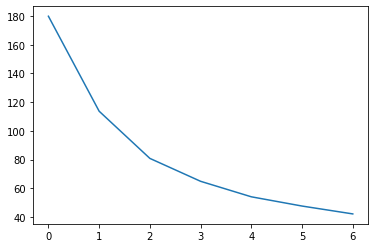

In [16]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    y = kmeans.fit_predict(rfm_ds_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

### Silhouette Analysis
##### silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)
##### 𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of
##### 𝑞  is the mean intra-cluster distance to all the points in its own cluster.
##### The value of the silhouette score range lies between -1 to 1.
##### A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
##### A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [17]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.5889064222823147
For n_clusters=3, the silhouette score is 0.5489370253660052
For n_clusters=4, the silhouette score is 0.5038222293825055
For n_clusters=5, the silhouette score is 0.4482408170286267
For n_clusters=6, the silhouette score is 0.4039241725015655
For n_clusters=7, the silhouette score is 0.385891377443151
For n_clusters=8, the silhouette score is 0.3881623034152421


In [18]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit_predict(rfm_ds_scaled)
cluster_labels = kmeans.labels_
silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
compare.append(silhouette_avg)

In [19]:
rfm_ds_final['Cluster_Id'] = lbs
RFM_kmeans=rfm_ds_final.copy()
rfm_ds_final.head()

CustomerID   Amount  Frequency  Recency  Cluster_Id
0    12346.0     0.00          2      325           1
1    12347.0  4310.00        182        1           2
2    12348.0  1797.24         31       74           0
3    12349.0  1757.55         73       18           0
4    12350.0   334.40         17      309           1

<AxesSubplot: xlabel='Cluster_Id', ylabel='Amount'>

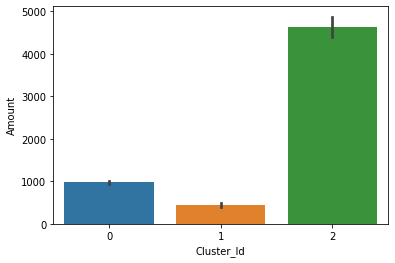

In [20]:
sns.barplot(x='Cluster_Id', y='Amount', data=rfm_ds_final)

<AxesSubplot: xlabel='Cluster_Id', ylabel='Frequency'>

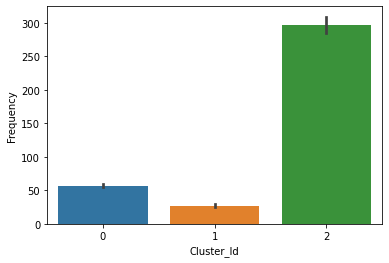

In [21]:
sns.barplot(x='Cluster_Id', y='Frequency', data=rfm_ds_final)

<AxesSubplot: xlabel='Cluster_Id', ylabel='Recency'>

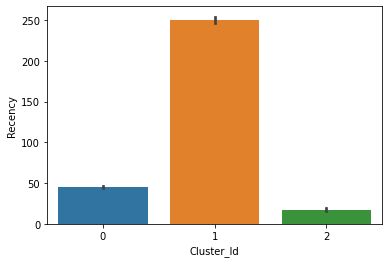

In [22]:
sns.barplot(x='Cluster_Id', y='Recency', data=rfm_ds_final)

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
%matplotlib inline

In [24]:
import plotly
import plotly.graph_objs as go

#Set marker properties
markercolor = rfm_ds_final['Cluster_Id']

#Make Plotly figure
fig1 = go.Scatter3d(x=rfm_ds_final['Amount'],
                    y=rfm_ds_final['Recency'],
                    z=rfm_ds_final['Frequency'],
                    marker=dict(color=markercolor,
                                opacity=1,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="Amount"),
                                yaxis=dict( title="Recency"),
                                zaxis=dict(title="Frequency")),)

#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("4DPlot"))

'4DPlot.png.html'

In [25]:
fig = px.scatter_3d(RFM_kmeans, x='Frequency', y='Amount', z='Recency',
              color= 'Cluster_Id')
fig.show()  

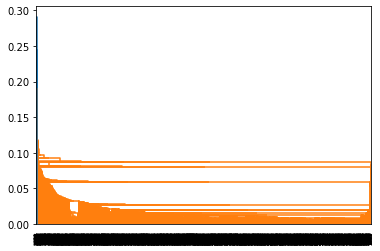

In [26]:
# Heirarchical clustering
mergings = linkage(rfm_ds_scaled, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

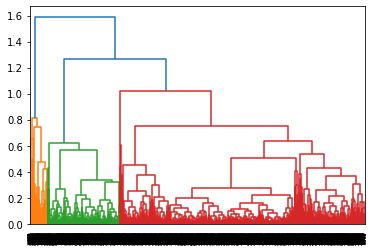

In [27]:
mergings = linkage(rfm_ds_scaled, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [28]:
rfm_ds_final=rfm_ds_final.drop(columns=['Cluster_Id'])

In [29]:
rfm_ds_final.head()

CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309

In [30]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([rfm_ds_final, clusterCut], axis=1)
RFM_hc.head()
RFM_hc.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency', 'Cluster_ID']

In [31]:
RFM_hc.head()

CustomerID   Amount  Frequency  Recency  Cluster_ID
0    12346.0     0.00        2.0    325.0         0.0
1    12347.0  4310.00      182.0      1.0         1.0
2    12348.0  1797.24       31.0     74.0         1.0
3    12349.0  1757.55       73.0     18.0         1.0
4    12350.0   334.40       17.0    309.0         0.0

In [32]:
km_clusters_amount = pd.DataFrame(RFM_hc.groupby(["Cluster_ID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_hc.groupby(["Cluster_ID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_hc.groupby(["Cluster_ID"]).Recency.mean())

In [33]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

ClusterID  Amount_mean  Frequency_mean  Recency_mean
0.0          0  1182.403879       74.996667     99.668889
1.0          1  1297.355040       78.852980     90.207924
2.0          2  1250.816330       78.760638     87.031915
3.0          3  1342.036000       67.342857    121.685714
4.0          4  1381.769737       69.657895    100.631579

<AxesSubplot: xlabel='ClusterID', ylabel='Amount_mean'>

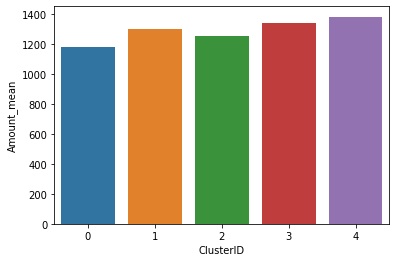

In [34]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

<AxesSubplot: xlabel='ClusterID', ylabel='Frequency_mean'>

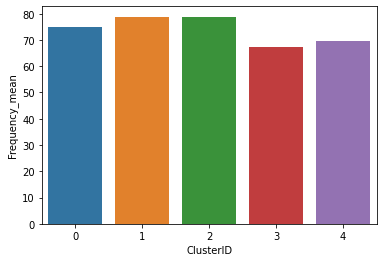

In [35]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot: xlabel='ClusterID', ylabel='Recency_mean'>

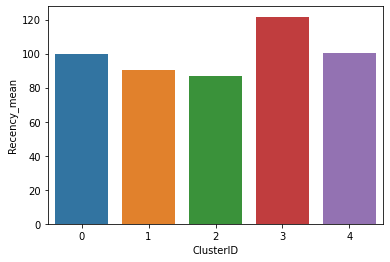

In [36]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

In [37]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
import plotly.graph_objects as go


In [38]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2,15):
    clusterer = AgglomerativeClustering (n_clusters=n_clusters, distance_threshold = None)
    preds = clusterer.fit_predict(rfm_ds_scaled)
    score = silhouette_score (rfm_ds_scaled, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))


For n_clusters = 2, silhouette score is 0.5899215868365306)
For n_clusters = 3, silhouette score is 0.48805757205632033)
For n_clusters = 4, silhouette score is 0.453006608127441)
For n_clusters = 5, silhouette score is 0.33112188925478564)
For n_clusters = 6, silhouette score is 0.3400957391721419)
For n_clusters = 7, silhouette score is 0.3304393826419998)
For n_clusters = 8, silhouette score is 0.31665559155867773)
For n_clusters = 9, silhouette score is 0.29655922168122945)
For n_clusters = 10, silhouette score is 0.3050974600532711)
For n_clusters = 11, silhouette score is 0.2963279125859147)
For n_clusters = 12, silhouette score is 0.29626942656805666)
For n_clusters = 13, silhouette score is 0.30095898061724113)
For n_clusters = 14, silhouette score is 0.30537437253424343)


In [39]:
clusterer = AgglomerativeClustering (n_clusters=4, distance_threshold = None)
preds = clusterer.fit_predict(rfm_ds_scaled)
score = silhouette_score (rfm_ds_scaled, preds)
compare.append(score)

In [40]:
from sklearn.metrics import davies_bouldin_score

for n_clusters in range(2,10):
    clusterer = AgglomerativeClustering (n_clusters=n_clusters, distance_threshold = None)
    preds = clusterer.fit_predict(rfm_ds_scaled)
    
    score = davies_bouldin_score (rfm_ds_scaled , preds)
    print ("For n_clusters = {}, the Davies-Bouldin score is {})".format(n_clusters, score))

For n_clusters = 2, the Davies-Bouldin score is 0.5826617563509366)
For n_clusters = 3, the Davies-Bouldin score is 0.8309697925956766)
For n_clusters = 4, the Davies-Bouldin score is 0.7836061485357533)
For n_clusters = 5, the Davies-Bouldin score is 0.8167538580230037)
For n_clusters = 6, the Davies-Bouldin score is 0.8263187624643519)
For n_clusters = 7, the Davies-Bouldin score is 0.8510039603897949)
For n_clusters = 8, the Davies-Bouldin score is 0.9766485969490258)
For n_clusters = 9, the Davies-Bouldin score is 0.9894615144697736)


In [41]:
from sklearn.metrics import calinski_harabasz_score

for n_clusters in range(2,10):
    clusterer = AgglomerativeClustering (n_clusters=n_clusters, distance_threshold = None)
    preds = clusterer.fit_predict(rfm_ds_scaled)
    
    score = calinski_harabasz_score(rfm_ds_scaled, preds)
    print ("For n_clusters = {}, the Calinski-Harabasz score is {})".format(n_clusters, score))

For n_clusters = 2, the Calinski-Harabasz score is 6162.5776181800065)
For n_clusters = 3, the Calinski-Harabasz score is 5694.878643932515)
For n_clusters = 4, the Calinski-Harabasz score is 4968.431224729715)
For n_clusters = 5, the Calinski-Harabasz score is 4757.058888294042)
For n_clusters = 6, the Calinski-Harabasz score is 4987.204834344015)
For n_clusters = 7, the Calinski-Harabasz score is 4758.861411324969)
For n_clusters = 8, the Calinski-Harabasz score is 4685.296061960849)
For n_clusters = 9, the Calinski-Harabasz score is 4696.191539284417)


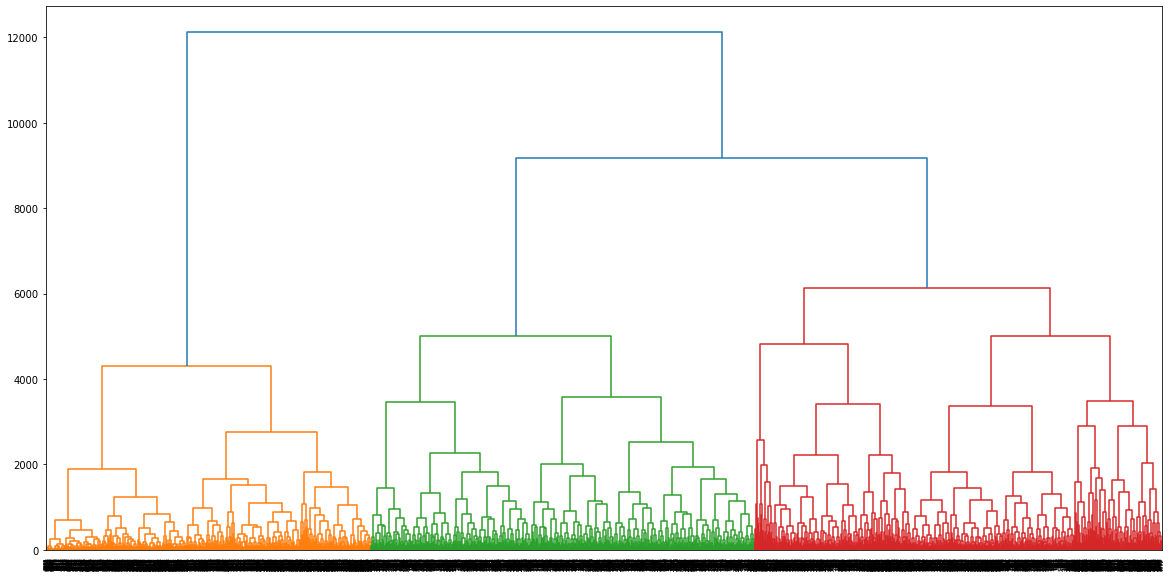

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

model = AgglomerativeClustering(distance_threshold=0, n_clusters = None)
model = model.fit(rfm_ds_scaled)

Z = hierarchy.linkage(model.children_, 'complete')

plt.figure(figsize=(20,10))

dn = hierarchy.dendrogram(Z)

In [43]:
import seaborn as sns

model = AgglomerativeClustering(distance_threshold=None, n_clusters = 3)
model = model.fit(rfm_ds_scaled)
y_agg=model.fit_predict(rfm_ds_scaled)

In [44]:
RFM_agg = rfm_ds_final.copy()

RFM_agg['Agg_Labels'] = y_agg

fig = px.scatter_3d(RFM_agg, x='Frequency', y='Amount', z='Recency',
              color= 'Agg_Labels')
fig.show()

[5.56631091e-06 5.56631091e-06 4.17473318e-05 ... 1.90228170e-01
 2.44693706e-01 2.90854640e-01]


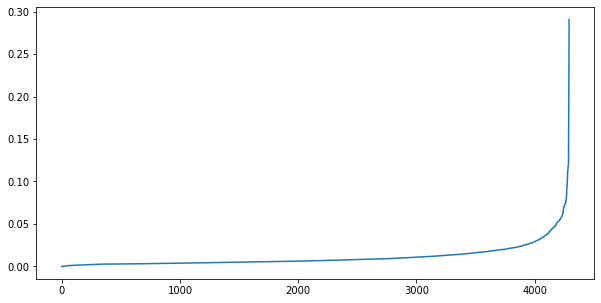

In [45]:
#DBSCAN
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=65) #sqrt(samples = 4293)
nearest_neighbors.fit(rfm_ds_scaled)
distances, indices = nearest_neighbors.kneighbors(rfm_ds_scaled)
distances = np.sort(distances, axis=0)[:, 1]
print(distances)
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.show()

In [46]:
from sklearn.cluster import DBSCAN

model2 = DBSCAN(eps = 0.05, min_samples = 13)

model2 = model2.fit(rfm_ds_scaled)

y_db=model2.labels_

RFM_DB = rfm_ds_final.copy()
RFM_DB["DBLabels"] = y_db

RFM_DB["DBLabels"].value_counts(0)

 0    3906
-1     387
Name: DBLabels, dtype: int64

In [47]:
silhouette_score (RFM_DB, y_db)
compare.append(silhouette_score (RFM_DB, y_db))

In [48]:
fig = px.scatter_3d(RFM_DB, x='Frequency', y='Amount', z='Recency',
              color= 'DBLabels')
fig.show()

In [49]:
RFM_DB_filtered = RFM_DB.copy()

# Get names of indexes for which column DB_Labels has value -1
indexNames = RFM_DB_filtered[ RFM_DB_filtered['DBLabels'] == -1 ].index
# Delete these row indexes from dataFrame
RFM_DB_filtered.drop(indexNames , inplace=True)

RFM_DB_filtered['DBLabels'].unique()


array([0], dtype=int64)

In [50]:
fig = px.scatter_3d(RFM_DB_filtered, x='Frequency', y='Amount', z='Recency',
              color= 'DBLabels')
fig.show()

In [51]:
#EM using GMM
from sklearn.mixture import GaussianMixture as GMM

for n_components in range(2,15):
    clusterer = GMM(n_components=n_components)
    preds = clusterer.fit_predict(rfm_ds_scaled)
    

    score = silhouette_score (rfm_ds_scaled, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_components, score))



For n_clusters = 2, silhouette score is 0.2132858084301228)
For n_clusters = 3, silhouette score is 0.10770516817758803)
For n_clusters = 4, silhouette score is 0.1055320549253763)
For n_clusters = 5, silhouette score is 0.06288751522614104)
For n_clusters = 6, silhouette score is 0.05092278246629831)
For n_clusters = 7, silhouette score is 0.10165361180352774)
For n_clusters = 8, silhouette score is 0.05551340062770129)
For n_clusters = 9, silhouette score is 0.06304044057510537)
For n_clusters = 10, silhouette score is 0.05529329516985368)
For n_clusters = 11, silhouette score is 0.023719311104499367)
For n_clusters = 12, silhouette score is 0.011979841101745468)
For n_clusters = 13, silhouette score is 0.013652563062906289)
For n_clusters = 14, silhouette score is -0.004791091161184025)


In [52]:
clusterer = GMM(n_components=4)
preds = clusterer.fit_predict(rfm_ds_scaled)
score = silhouette_score (rfm_ds_scaled, preds)
compare.append(score)

Automatically created module for IPython interactive environment


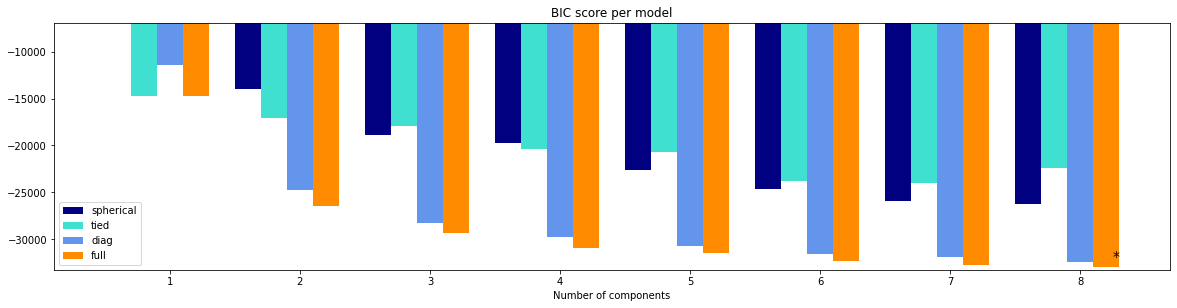

In [53]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl



print(__doc__)



lowest_bic = np.infty
bic = []
n_components_range = range(1, 9)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GMM(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(rfm_ds_scaled)
        bic.append(gmm.bic(rfm_ds_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(20, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

Text(0.5, 0, 'n_components')

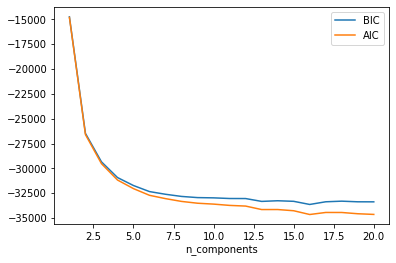

In [54]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(rfm_ds_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(rfm_ds_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rfm_ds_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [55]:
RFM_gmm = rfm_ds_final.copy()

RFM_gmm['gmm'] = GMM(n_components=4, random_state=42).fit_predict(rfm_ds_scaled)

In [56]:
fig = px.scatter_3d(RFM_gmm, x='Frequency', y='Amount', z='Recency',
              color= 'gmm')
fig.show()

In [57]:
import plotly.io as pio

In [58]:
max = 0
algorithms = ["KMeans","AgglomerativeClustering","DBSCAN","GMM"]

for i in range (0, 4):
    print(algorithms[i], " : ", compare[i])
    if compare[max]<compare[i]:
       max=i
if max == 0:
  print("The best algorithm is K-Means with silhouette score of ",compare[max])
  print(RFM_kmeans)
  message = "The best algorithm is K-Means"
  fig = px.scatter_3d(RFM_kmeans, x='Frequency', y='Amount', z='Recency',
              color= 'Cluster_Id')
  fig.show()  
elif max==1:
  print("The best algorithm is Agglomerative with silhouette score of ",compare[max])
  print("Agglomerative")
  print(RFM_agg)
  fig = px.scatter_3d(RFM_agg, x='Frequency', y='Amount', z='Recency',
              color= 'agg')
  fig.show()
elif max==2:
  print("The best algorithm is DBSCAN with silhouette score of ",compare[max])
  print(RFM_DB_filtered)
  fig = px.scatter_3d(RFM_DB_filtered, x='Frequency', y='Amount', z='Recency',
              color= 'DBLabels')
  fig.show()
else:
  print("The best algorithm is GMM with silhouette score of ",compare[max])
  print(RFM_gmm)
  fig = px.scatter_3d(RFM_gmm, x='Frequency', y='Amount', z='Recency',
              color= 'gmm')
  fig.show()
  
     

KMeans  :  0.5481982074749173
AgglomerativeClustering  :  0.453006608127441
DBSCAN  :  0.44312385040472246
GMM  :  0.10256240721947996
The best algorithm is K-Means with silhouette score of  0.5481982074749173
     CustomerID   Amount  Frequency  Recency  Cluster_Id
0       12346.0     0.00          2      325           1
1       12347.0  4310.00        182        1           2
2       12348.0  1797.24         31       74           0
3       12349.0  1757.55         73       18           0
4       12350.0   334.40         17      309           1
...         ...      ...        ...      ...         ...
4366    18278.0   173.90          9       73           0
4367    18280.0   180.60         10      277           1
4368    18281.0    80.82          7      180           1
4369    18282.0   176.60         13        7           0
4371    18287.0  1837.28         70       42           0

[4293 rows x 5 columns]
The best algorithm is K-Means
